## Probit model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from IPython.display import display

Because the cumulative distribution function of the standard normal distribution is not available, we define it here.

In [2]:
def normal_cdf(x):
    return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))

The following cell generates data from 

$$
 y_i = \begin{cases}
 1, & \text{with probability}\quad \mu_i; \\
 0, & \text{with probability}\quad 1-\mu_i.
 \end{cases}
$$

$$
 \Phi^{-1}(\mu_i) = 0.5 x_{1i} - 0.5 x_{2i},\quad i=1,\dots,500.
$$

In [3]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.norm.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [4]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
probit_model = pm.Model()
with probit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', p=normal_cdf(idx), observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with probit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123, return_inferencedata=False)
    results = az.summary(trace)
var_names = ['$\\beta_{:d}$'.format(index) for index in range(k)]
results.index = var_names
sim_param = dict([(var, trace['b'][:, index]) for index, var in enumerate(var_names)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.graph.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.graph.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/teruo/opt/miniforge3/envs/bayes/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/teruo/opt/miniforge3/envs/bayes/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/teruo/opt/miniforge3/envs/bayes/lib/python3.9/site-packages/theano/tensor/opt.py", line 7291, in local_grad_log_erfc_neg
    if not exp_in.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 28 seconds.


In [5]:
display(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
$\beta_0$,-0.055,0.061,-0.169,0.058,0.0,0.0,25907.0,16660.0,25888.0,15799.0,1.0
$\beta_1$,0.437,0.064,0.317,0.554,0.0,0.0,24454.0,24085.0,24385.0,13647.0,1.0
$\beta_2$,-0.468,0.064,-0.586,-0.349,0.0,0.0,24598.0,24360.0,24579.0,15094.0,1.0


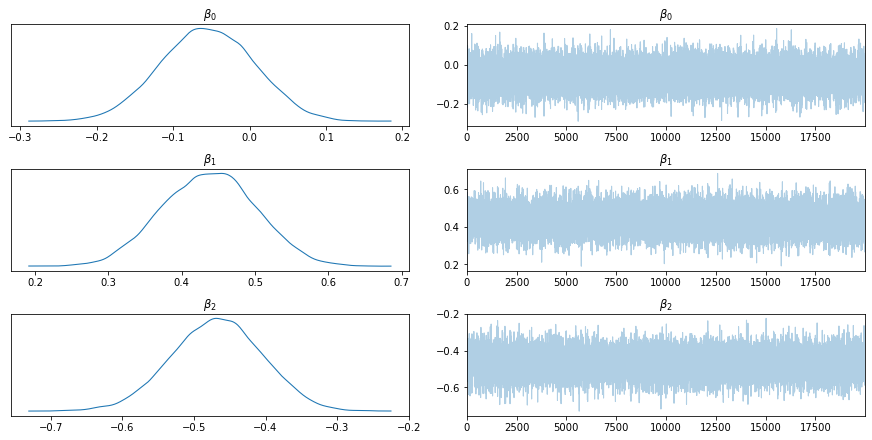

In [6]:
az.plot_trace(sim_param)
plt.show()

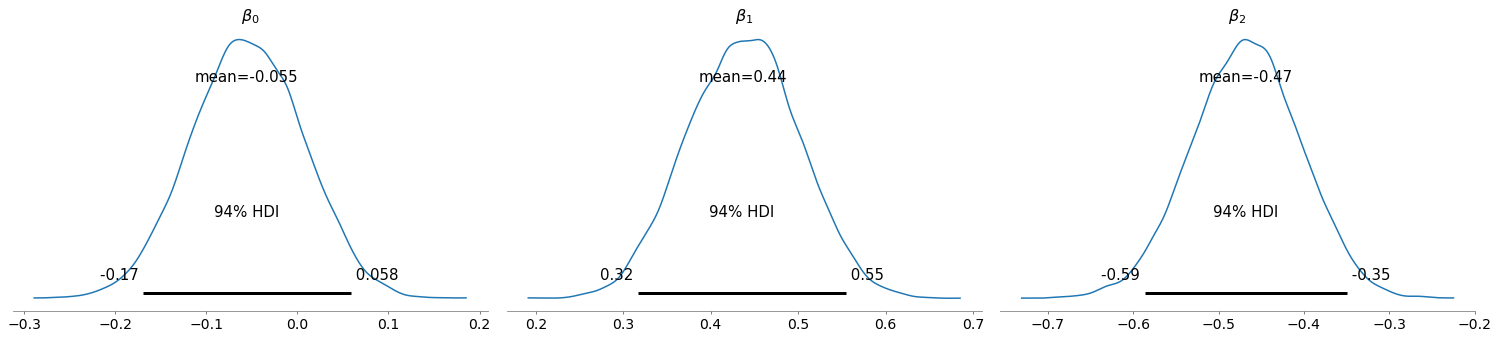

In [7]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()